# 00 - Descarga de Datos Climáticos desde Google Earth Engine

**Proyecto:** EDA de Dengue en Colombia  
**Maestría en Inteligencia Artificial** - Desarrollo de Soluciones  

Este notebook descarga variables climáticas asociadas a la transmisión del dengue para los municipios de Colombia, usando Google Earth Engine (GEE).

**Variables a extraer:**
- Temperatura superficial (MODIS/061/MOD11A2)
- Precipitación (UCSB-CHG/CHIRPS/DAILY)
- NDVI - Índice de vegetación (MODIS/061/MOD13A2)
- Humedad relativa (ERA5-Land / ECMWF)

**Años de interés:** 2010, 2016, 2019, 2022, 2024  
**Resolución temporal:** Promedios mensuales por departamento

### Requisitos
- Cuenta activa en [Google Earth Engine](https://earthengine.google.com)
- Librería `earthengine-api` instalada (`pip install earthengine-api`)

In [1]:
import ee
import pandas as pd
import numpy as np
import os
import sys
import time

sys.path.insert(0, os.path.join('..', 'src'))
from utils import DATA_DIR, CLIMA_DIR, ANOS_ESTUDIO

In [2]:
import ee
ee.Authenticate(auth_mode='notebook')

True

## 1. Autenticación e inicialización de GEE

La primera vez se abrirá una ventana del navegador para autenticarse con Google.

In [ ]:
#TODO: OJO colocar el nombre del proyecto de GEE que se va a usar
# Autenticacion (solo la primera vez)
# ee.Authenticate()

# Inicializar - usar el proyecto de GEE correspondiente
ee.Initialize(project='nombre-del-proyecto')
ee.Initialize()
print('Google Earth Engine inicializado correctamente.')

Google Earth Engine inicializado correctamente.


## 2. Definir geometrías de departamentos de Colombia

Usamos la colección de límites administrativos de FAO/GAUL disponible en GEE para obtener los departamentos de Colombia. Agregamos por **departamento** para reducir el volumen de consultas.

In [ ]:
ee.Initialize(project='nombre-del-proyecto')

colombia = (ee.FeatureCollection('FAO/GAUL/2015/level1')
            .filter(ee.Filter.eq('ADM0_NAME', 'Colombia')))

deptos = colombia.aggregate_array('ADM1_NAME').getInfo()
print(f'Departamentos encontrados: {len(deptos)}')
for d in sorted(deptos):
    print(f'  - {d}')

Departamentos encontrados: 33
  - Amazonas
  - Antioquia
  - Arauca
  - Atlantico
  - Bolivar
  - Boyaca
  - Buenaventura
  - Caldas
  - Caqueta
  - Casanare
  - Cauca
  - Cesar
  - Choco
  - Cordoba
  - Cundinamarca
  - Guainia
  - Guajira
  - Guaviare
  - Huila
  - Magdalena
  - Meta
  - Narino
  - Norte De Santander
  - Putumayo
  - Quindio
  - Risaralda
  - San Andres Y Providencia
  - Santander
  - Sucre
  - Tolima
  - Valle Del Cauca
  - Vaupes
  - Vichada


## 3. Funciones de extracción de datos climáticos

Definimos funciones para extraer promedios mensuales de cada variable climática por departamento.

In [5]:
def extraer_promedios_mensuales(dataset_id, banda, region, ano, meses=range(1, 13),
                                 escala=10000, reducer='mean', factor=1.0):
    """
    Extrae promedios mensuales de un dataset de GEE para una region y ano dados.
    
    Parameters
    ----------
    dataset_id : str - ID del dataset en GEE
    banda : str - Nombre de la banda a extraer
    region : ee.Geometry - Region de interes
    ano : int - Ano de interes
    meses : range - Meses a extraer
    escala : int - Escala en metros para reduceRegion
    reducer : str - Tipo de reductor ('mean' o 'sum')
    factor : float - Factor de conversion (ej: 0.02 para LST de MODIS)
    
    Returns
    -------
    list[dict] - Lista con {mes, valor}
    """
    resultados = []
    
    for mes in meses:
        # Definir rango de fechas
        inicio = ee.Date.fromYMD(ano, mes, 1)
        if mes == 12:
            fin = ee.Date.fromYMD(ano + 1, 1, 1)
        else:
            fin = ee.Date.fromYMD(ano, mes + 1, 1)
        
        # Filtrar coleccion
        coleccion = (ee.ImageCollection(dataset_id)
                     .filterDate(inicio, fin)
                     .select(banda))
        
        # Reducir temporalmente
        if reducer == 'sum':
            imagen = coleccion.sum()
        else:
            imagen = coleccion.mean()
        
        # Reducir espacialmente
        try:
            stats = imagen.reduceRegion(
                reducer=ee.Reducer.mean(),
                geometry=region,
                scale=escala,
                maxPixels=1e9
            ).getInfo()
            
            valor = stats.get(banda)
            if valor is not None:
                valor = valor * factor
            resultados.append({'mes': mes, 'valor': valor})
        except Exception as e:
            print(f'  Error en {ano}-{mes:02d}: {e}')
            resultados.append({'mes': mes, 'valor': None})
    
    return resultados

In [6]:
def extraer_clima_departamento(depto_feature, ano):
    """
    Extrae las 4 variables climaticas para un departamento y ano.
    
    Returns
    -------
    list[dict] - Registros con {departamento, ano, mes, temperatura, precipitacion, ndvi, humedad}
    """
    nombre = depto_feature.get('ADM1_NAME').getInfo()
    region = depto_feature.geometry()
    
    print(f'  Procesando {nombre} - {ano}...')
    
    # 1. Temperatura superficial (MODIS LST)
    # Banda LST_Day_1km, factor de escala 0.02, resultado en Kelvin -> convertir a Celsius
    temp = extraer_promedios_mensuales(
        'MODIS/061/MOD11A2', 'LST_Day_1km', region, ano,
        escala=1000, factor=0.02
    )
    
    # 2. Precipitacion (CHIRPS)
    # Banda precipitation, acumulado mensual en mm
    precip = extraer_promedios_mensuales(
        'UCSB-CHG/CHIRPS/DAILY', 'precipitation', region, ano,
        escala=5000, reducer='sum'
    )
    
    # 3. NDVI (MODIS)
    # Banda NDVI, factor de escala 0.0001
    ndvi = extraer_promedios_mensuales(
        'MODIS/061/MOD13A2', 'NDVI', region, ano,
        escala=1000, factor=0.0001
    )
    
    # 4. Humedad (ERA5-Land)
    # dewpoint_temperature_2m como proxy de humedad
    humedad = extraer_promedios_mensuales(
        'ECMWF/ERA5_LAND/MONTHLY_AGGR', 'dewpoint_temperature_2m', region, ano,
        escala=11000, factor=1.0
    )
    
    # Combinar resultados
    registros = []
    for i, mes in enumerate(range(1, 13)):
        temp_c = temp[i]['valor']
        if temp_c is not None:
            temp_c = temp_c - 273.15  # Kelvin a Celsius
        
        hum_c = humedad[i]['valor']
        if hum_c is not None:
            hum_c = hum_c - 273.15  # Kelvin a Celsius
        
        registros.append({
            'departamento': nombre,
            'ano': ano,
            'mes': mes,
            'temperatura_c': round(temp_c, 2) if temp_c is not None else None,
            'precipitacion_mm': round(precip[i]['valor'], 2) if precip[i]['valor'] is not None else None,
            'ndvi': round(ndvi[i]['valor'], 4) if ndvi[i]['valor'] is not None else None,
            'dewpoint_c': round(hum_c, 2) if hum_c is not None else None,
        })
    
    return registros

## 4. Extracción masiva de datos climáticos

Iteramos sobre todos los departamentos y años de interés. Este proceso puede tomar un tiempo considerable debido a las consultas a GEE.

**Nota:** Se incluyen pausas entre consultas para respetar los límites de la API.

In [7]:
# Crear directorio de salida
os.makedirs(CLIMA_DIR, exist_ok=True)

# Obtener features de departamentos
deptos_list = colombia.toList(colombia.size())
n_deptos = colombia.size().getInfo()

print(f'Extrayendo datos climaticos para {n_deptos} departamentos y {len(ANOS_ESTUDIO)} anos...')
print(f'Anos: {ANOS_ESTUDIO}')
print()

Extrayendo datos climaticos para 33 departamentos y 5 anos...
Anos: [2010, 2016, 2019, 2022, 2024]



In [8]:
# EXTRACCION PRINCIPAL
# Este bloque puede tardar bastante. Se guarda progreso parcial por ano.

todos_los_registros = []

for ano in ANOS_ESTUDIO:
    print(f'\n{"="*60}')
    print(f'  ANO: {ano}')
    print(f'{"="*60}')
    
    registros_ano = []
    
    for i in range(n_deptos):
        depto = ee.Feature(deptos_list.get(i))
        try:
            registros = extraer_clima_departamento(depto, ano)
            registros_ano.extend(registros)
            time.sleep(1)  # Pausa para no sobrecargar la API
        except Exception as e:
            nombre = depto.get('ADM1_NAME').getInfo()
            print(f'  ERROR en {nombre}: {e}')
            continue
    
    # Guardar progreso parcial
    df_ano = pd.DataFrame(registros_ano)
    df_ano.to_csv(CLIMA_DIR / f'clima_{ano}.csv', index=False)
    print(f'  Guardado: clima_{ano}.csv ({len(df_ano)} registros)')
    
    todos_los_registros.extend(registros_ano)

print(f'\nExtraccion completada. Total: {len(todos_los_registros)} registros.')


  ANO: 2010
  Procesando Amazonas - 2010...
  Procesando Antioquia - 2010...
  Procesando Arauca - 2010...
  Procesando Atlantico - 2010...
  Procesando Bolivar - 2010...
  Procesando Boyaca - 2010...
  Procesando Buenaventura - 2010...
  Procesando Caldas - 2010...
  Procesando Caqueta - 2010...
  Procesando Casanare - 2010...
  Procesando Cauca - 2010...
  Procesando Cesar - 2010...
  Procesando Choco - 2010...
  Procesando Cordoba - 2010...
  Procesando Cundinamarca - 2010...
  Procesando Guainia - 2010...
  Procesando Guajira - 2010...
  Procesando Guaviare - 2010...
  Procesando Huila - 2010...
  Procesando Magdalena - 2010...
  Procesando Meta - 2010...
  Procesando Narino - 2010...
  Procesando Norte De Santander - 2010...
  Procesando Putumayo - 2010...
  Procesando Quindio - 2010...
  Procesando Risaralda - 2010...
  Procesando San Andres Y Providencia - 2010...
  Procesando Santander - 2010...
  Procesando Sucre - 2010...
  Procesando Tolima - 2010...
  Procesando Valle Del 

In [9]:
# Consolidar todos los datos climaticos en un solo archivo
df_clima = pd.DataFrame(todos_los_registros)
df_clima.to_csv(CLIMA_DIR / 'clima_consolidado.csv', index=False)
print(f'Archivo consolidado guardado: clima_consolidado.csv')
print(f'Dimensiones: {df_clima.shape}')
df_clima.head(10)

Archivo consolidado guardado: clima_consolidado.csv
Dimensiones: (1980, 7)


,departamento,ano,mes,temperatura_c,precipitacion_mm,ndvi,dewpoint_c
0,Amazonas,2010,1,28.93,242.85,0.8265,23.55
1,Amazonas,2010,2,29.64,251.34,0.7891,24.40
2,Amazonas,2010,3,28.78,347.76,0.7483,24.33
3,Amazonas,2010,4,27.56,367.11,0.6040,24.03
4,Amazonas,2010,5,27.42,347.34,0.6145,23.40
5,Amazonas,2010,6,26.87,323.35,0.7573,23.10
6,Amazonas,2010,7,26.98,239.44,0.8038,22.52
7,Amazonas,2010,8,27.64,210.67,0.8106,22.91
8,Amazonas,2010,9,29.38,252.13,0.8169,23.68
9,Amazonas,2010,10,29.08,194.10,0.7839,23.78


## 5. Verificación y exploración rápida

In [10]:
# Verificar datos descargados
print('Resumen de datos climaticos:')
print(df_clima.describe())
print(f'\nValores nulos por columna:')
print(df_clima.isnull().sum())
print(f'\nDepartamentos unicos: {df_clima["departamento"].nunique()}')
print(f'Anos: {sorted(df_clima["ano"].unique())}')

Resumen de datos climaticos:
               ano          mes  temperatura_c  precipitacion_mm         ndvi  \
count  1980.000000  1980.000000    1980.000000       1920.000000  1980.000000   
mean   2018.200000     6.500000      27.141409        222.527146     0.625150   
std       4.916524     3.452925       3.637121        133.214817     0.111137   
min    2010.000000     1.000000      17.980000          0.650000     0.102400   
25%    2016.000000     3.750000      24.460000        125.017500     0.556550   
50%    2019.000000     6.500000      27.040000        218.170000     0.633450   
75%    2022.000000     9.250000      29.272500        304.190000     0.701725   
max    2024.000000    12.000000      39.610000        973.790000     0.862300   

        dewpoint_c  
count  1860.000000  
mean     19.509290  
std       3.811328  
min       9.730000  
25%      16.300000  
50%      20.945000  
75%      22.750000  
max      25.530000  

Valores nulos por columna:
departamento          0


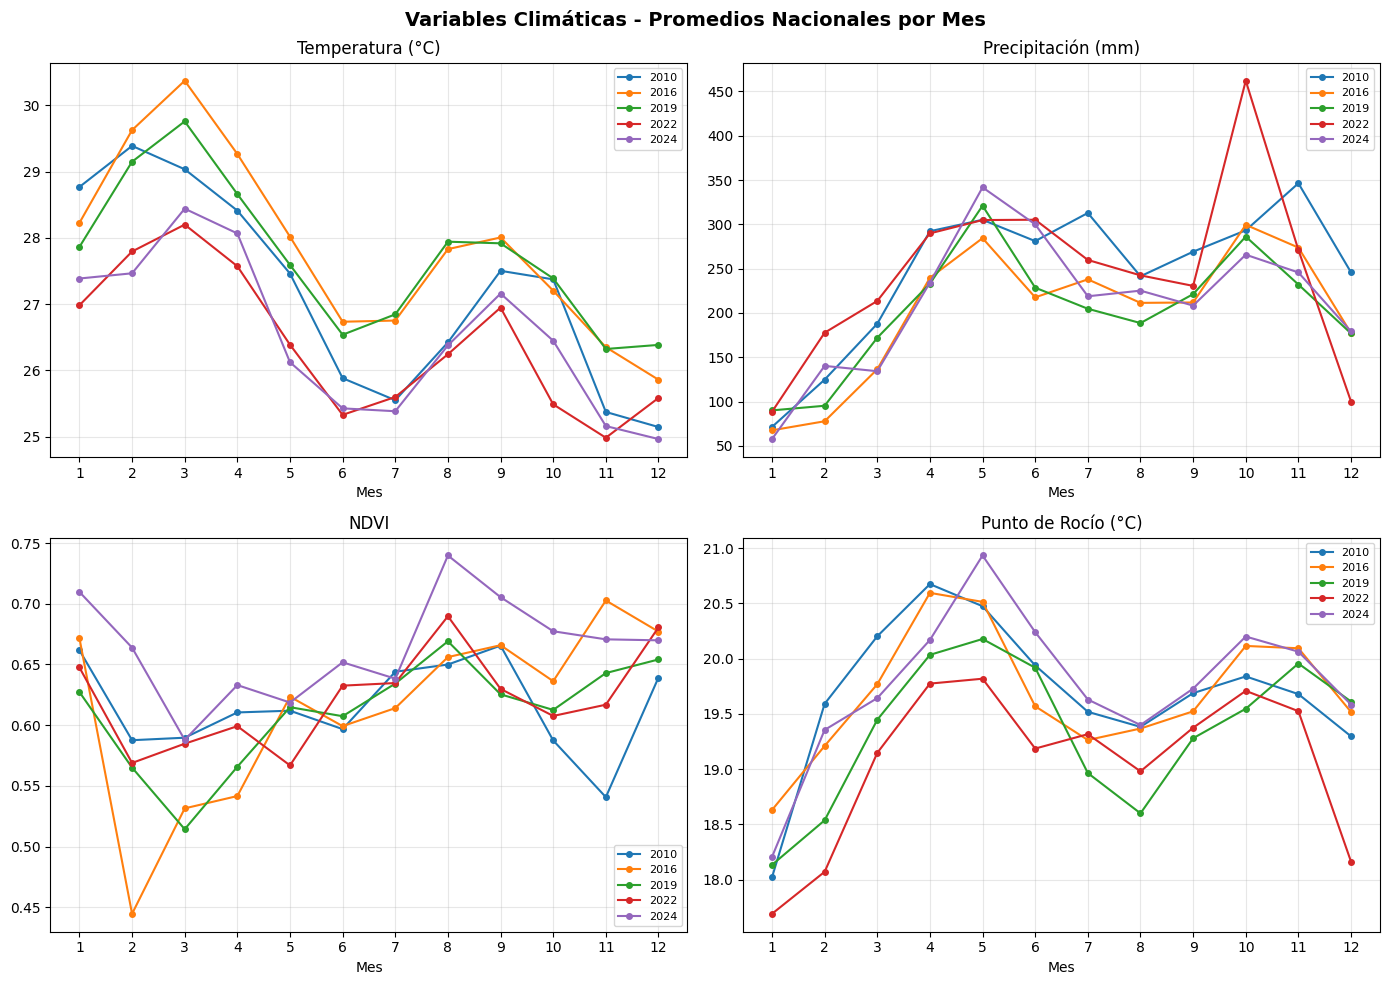

In [11]:
import matplotlib.pyplot as plt

# Visualizacion rapida de promedios nacionales
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('Variables Climáticas - Promedios Nacionales por Mes', fontsize=14, fontweight='bold')

variables = [
    ('temperatura_c', 'Temperatura (°C)', axes[0, 0]),
    ('precipitacion_mm', 'Precipitación (mm)', axes[0, 1]),
    ('ndvi', 'NDVI', axes[1, 0]),
    ('dewpoint_c', 'Punto de Rocío (°C)', axes[1, 1]),
]

for var, titulo, ax in variables:
    for ano in ANOS_ESTUDIO:
        datos = df_clima[df_clima['ano'] == ano].groupby('mes')[var].mean()
        ax.plot(datos.index, datos.values, marker='o', markersize=4, label=str(ano))
    ax.set_title(titulo)
    ax.set_xlabel('Mes')
    ax.set_xticks(range(1, 13))
    ax.legend(fontsize=8)
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Limitaciones

- **Resolución espacial:** Los datos se agregan a nivel de departamento. MODIS tiene resolución de ~1km, CHIRPS ~5km, ERA5-Land ~11km.
- **Cobertura temporal:** CHIRPS está disponible desde 1981, MODIS desde ~2000, ERA5-Land desde 1950. Todos cubren nuestros años de interés.
- **Nubosidad:** MODIS (LST y NDVI) puede tener gaps por cobertura de nubes. Se usa el promedio mensual para mitigar esto.
- **Proxy de humedad:** Se usa la temperatura de punto de rocío (dewpoint) como proxy de humedad relativa, ya que ERA5-Land no provee humedad relativa directamente en GEE.
- **Año 2024:** Algunos datasets pueden tener datos incompletos para 2024 dependiendo de la fecha de actualización.